# AI Agent 이해와 주요 구성요소

**AI Agent**
- 스스로 의사 결정하며, 도구를 사용하여, 목표를 달성하는 시스템 → 문제를 스스로 해결하는 시스템
    - 도구 사용이나 다단계 추론을 활용
    - LLM을 중심으로 다양한 외부 도구를 연결하여 구축

**주요 구성 요소**

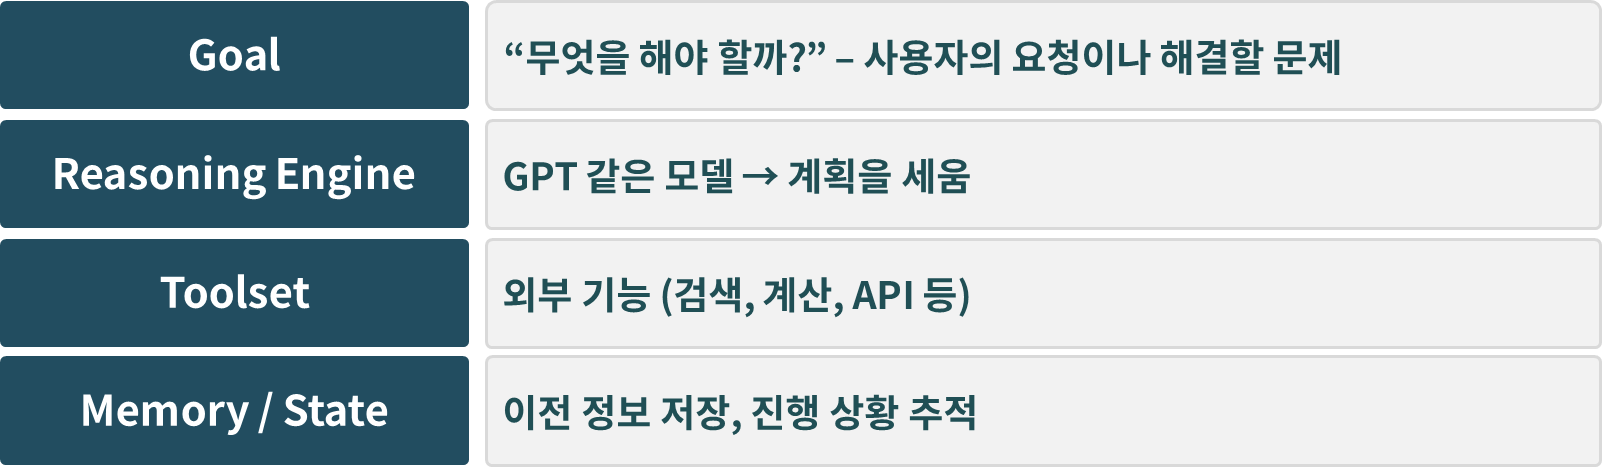

**LangGraph**
- AI Agent 간의 협업을 그래프 기반으로 설계하는 프레임워크
- 워크플로우(Workflow) : AI 에이전트들이 특정 목표를 위해 수행하는 일련의 과정 의미
- 복잡한 워크플로우를 처리하기 위해 그래프 구조가 필요.

**구성요소**
- 노드(Node)
    - 노드는 그래프에서 특정 작업이나 판단을 수행하는 단위를 의미
    - 각 노드는 파이썬 함수나 객체의 call 메서드로 구현
    - 예를 들어, 사용자의 질문을 이해하거나 필요한 정보를 검색하는 등의 작업을 담당
- 엣지(Edge)
    - 엣지는 노드 간의 연결을 나타내며, 작업의 흐름을 정의
    - 즉, 한 노드의 작업이 완료된 후 어떤 노드로 이동할지를 결정하는 역할
- 조건부 엣지(Conditional Edge)
    - 조건부 엣지는 특정 조건에 따라 노드 간의 분기 처리를 가능하게 함
    - 예를 들어, 특정 조건이 충족되면 A 노드에서 B 노드로 이동하고, 그렇지 않으면 C 노드로 이동
- 스테이트(State)
    - 스테이트는 그래프의 현재 상태 값을 저장 및 전달하는 역할
    - 대화 이력, 수집한 정보, 중간 결과 등을 포함
    - 각 노드는 이 state를 입력으로 받아 처리한 후 업데이트

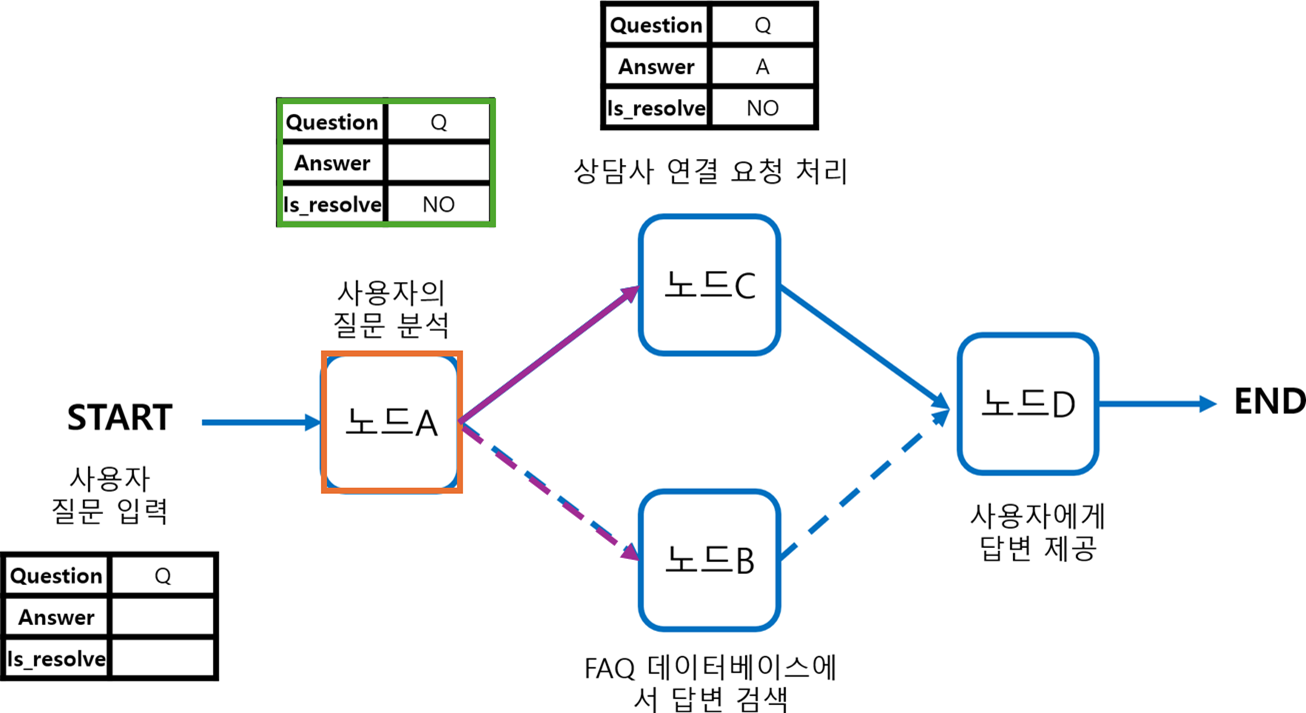



## **1.환경준비**

### (1) 구글 드라이브

#### 1) 구글 드라이브 폴더 생성
* 새 폴더(LangGraph)를 생성하고
* 제공 받은 파일을 업로드

#### 2) 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### (2) 라이브러리

#### 1) 필요한 라이브러리 설치
* 설치 후 세션 다시 시작

In [ ]:
!pip install langchain langgraph typing typing_extensions langchain-openai langchain_core langchain-community -q

#### 2) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import os
import openai
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### (3) OpenAI API Key 확인

In [ ]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/LangGraph/'

# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

* ⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 삭제하세요.

In [ ]:
print(os.environ['OPENAI_API_KEY'][:40])

## 2.Graph 구축① : 간단한 그래프

### (1) 간단한 그래프

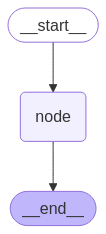

#### 1) State 정의
- 그래프의 노드의 입력과 출력 관리하는 딕셔너리 형태의 자료형
- 그래프를 통과하며, 컨텍스트를 유지 (각 노드는 입력과 출력을 State에 담아 처리)
- typing 모듈의 TypedDict 클래스를 사용.


In [ ]:
from typing import TypedDict

# 그래프 전체에서 주고받는 데이터 구조를 정의
class State(TypedDict):
    text: str
    extra_field: int

#### 2) Node 정의
- 입력 : State 구조
- 출력 : State 구조


In [ ]:
def node_1(state: State):
    print(state)
    # 입력: 상태 (state) → text 필드에 문자열을 덧붙임
    # extra_field은 무조건 10으로 덮어씀
    return {"text": state['text'] + "(텍스트 추가됨)", "extra_field": 10}

#### 3) 그래프 정의

In [ ]:
from langgraph.graph import StateGraph, START, END

# 그래프 초기화
builder = StateGraph(State)

# Node 추가
builder.add_node("node", node_1)  # "node"라는 이름으로 node_1 함수를 노드로 추가

# 노드 연결
builder.add_edge(START, "node")
builder.add_edge("node", END)

# 그래프 컴파일
graph = builder.compile()

* 그래프 시각화

In [ ]:
graph

#### 4) Graph 실행
- 입력 : State 딕셔너리 형식. 특정 키만 입력 가능
- 출력 : State 딕셔너리 형식.


In [ ]:
graph.invoke({"text" : "안녕!"})

### (2) 실습1

다음과 같은 그래프를 구축해 봅시다.
* node_1 : 위 함수 그대로 사용 가능
* node_2 : node_1을 그대로 사용해도 되고, 조금 변형해도 됨.

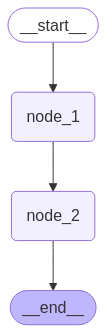

* State 정의  
(직접 코딩해 봅시다.)

In [ ]:
class State(TypedDict):
    text: str
    extra_field: int

* Node 정의

In [ ]:
# 노드 1: 텍스트에 문장 추가 + 필드 값 고정
def node_1(state: State):
    print("node_1 실행 전:", state)

    new_state = {
        "text": state["text"] + " → node_1에서 추가됨",
        "extra_field": 10
    }

    print("node_1 실행 후:", new_state)
    return new_state

# 노드 2: 텍스트에 추가 + 필드 증가
def node_2(state: State):





    return new_state

* 그래프 정의  
(직접 코딩해 봅시다.)


In [ ]:
# 그래프 생성
builder =

# 노드 등록
builder.add_node(   )
builder.add_node(   )

# 엣지 연결: START → node_1 → node_2 → END
builder.add_edge(    )



# 그래프 컴파일
graph =

* 그래프 시각화

In [ ]:
graph

* Graph 실행

In [ ]:
# 실행
initial_state = {"text": "처음 시작", "extra_field": 0}

result = graph.invoke(initial_state)
print("최종 결과:", result)

### (3) 실습2

* 입력값에 연산을 반복 적용하는 단방향 그래프를 만들어보자.
* 사용자로부터 숫자 하나를 입력받아, 다음 연산을 순서대로 수행하는 그래프(아래 그래프)를 구현하시오
    * 각 연산은 독립된 노드로 만들기 (double, square, add_five)
    * 최종 결과는 result 노드에서 출력되도록 구성
    * 상태 구조: {"value": 입력값} 형식 유지


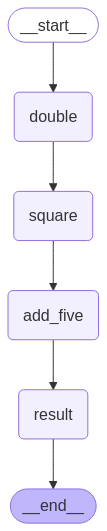

* State 정의  
(직접 코딩해 봅시다.)

In [ ]:
# 1. 상태 정의
from typing import TypedDict

class NumberState(TypedDict):
    value: int

* 노드 정의

In [ ]:
# 2. 노드 정의
def double_node(state: NumberState) -> NumberState:
    state["value"] *= 2
    print(f"[Double] => {state['value']}")
    return state

def square_node(state: NumberState) -> NumberState:


    return state

def add_five_node(state: NumberState) -> NumberState:


    return state

def result_node(state: NumberState) -> NumberState:


    return state

* 그래프 정의

In [ ]:
# 3. 그래프 정의


# 노드 연결


# 그래프 빌드



* 그래프 시각화

* 실행

In [ ]:
# 4. 실행
input_value = int(input("숫자를 입력하세요: "))
initial_state = {"value": input_value}
graph.invoke(initial_state)

## 3.State 다루기

### (1) State 값 변화

* 노드 2개: START → node_1 → node_2 → END
* State 필드 4개 사용
    * text: 누적 메시지 기록
    * user_id: 사용자 고유 ID
    * step: 현재 몇 번째 노드인지
    * history: 각 노드 처리 기록 저장 (리스트)

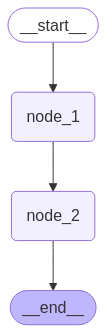

#### 1) State 정의

In [ ]:
class State(TypedDict):
    text: str
    user_id: str
    step: int
    history: list[str]

#### 2) Node 정의

In [ ]:
# node_1: 텍스트 변경 + step 증가 + 기록 저장
def node_1(state: State):
    print("node_1 실행 전 상태:", state)

    state["text"] += " → node_1 처리 완료"
    state["step"] += 1
    state["history"].append(f"node_1 완료 (step  {state['step']})")

    print("node_1 실행 후 상태:", state)
    return state

# node_2: 또 한 번 수정 + 기록 누적
def node_2(state: State):
    print("node_2 실행 전 상태:", state)

    state["text"] += " → node_2 처리 완료"
    state["step"] += 1
    state["history"].append(f"node_2 완료 (step {state['step']})")

    print("node_2 실행 후 상태:", state)
    return state

#### 3) 그래프 정의

In [ ]:
# 그래프 구성
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

graph = builder.compile()

* 그래프 시각화

In [ ]:
# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

#### 4) Graph 실행

In [ ]:
# 실행 : 함수로 실행
initial_state = {
    "text": "처음 요청 도착",
    "user_id": "user_1234",
    "step": 0,
    "history": []
}

# node_1
state = node_1(initial_state)
print(f'node_1 : {state}')

# node_1
state = node_2(state)
print(f'node_2 : {state}')

In [ ]:
# 실행 : graph로 실행
initial_state = {
    "text": "처음 요청 도착",
    "user_id": "user_1234",
    "step": 0,
    "history": []
}

result = graph.invoke(initial_state)
print("\n 최종 결과 상태:", result)

### (2) 실습1
유저 프로필 정보 누적 저장
* 요구사항
    * 그래프 : start → 이름 입력 → 나이 입력 → 이메일 입력 → 출력
        * 유저의 이름, 나이, 이메일 정보를 순차적으로 입력받아 상태(State)에 저장하는 과정을 연습하자.
    * 조건
        * 상태 구조는 {"name": str, "age": int, "email": str}
        * 각 노드는 입력값을 받아 상태에 반영
        * 최종 출력 노드에서 전체 상태를 출력할 것

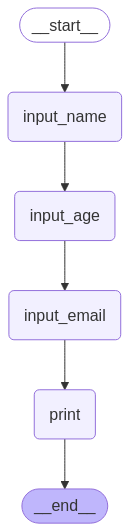

* 1) State 정의

In [ ]:
class ProfileState(TypedDict):
    name: str
    age: int
    email: str

* 2) Node 정의

* 3) 그래프 정의

* 그래프 시각화

* 4) Graph 실행


### (3) 실습2

* 요구사항
    * 노드 2개를 만들고, START → node_1 → node_2 → END 흐름으로 연결하시오.
    * node_1은 다음을 수행:
        * "score"에 10을 추가
        * "log"에 "node_1 completed"를 추가

    * node_2는 다음을 수행:
        * "score"에 5를 추가
        * "log"에 "node_2 completed"를 추가

    * 각 node_1, node_2의 실행 결과(state)를 출력하시오.
    * 최종 상태를 출력하시오.



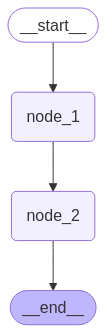

* State 정의

* Node 정의

* 그래프 정의

* 그래프 시각화

* Graph 실행

## 4.Graph 구축②: Routing

* workflow에서 Routing은 매우 중요합니다. *Routing*(라우팅) 은 특정 입력에 따라 서로 다른 경로를 선택하여 실행 흐름을 제어하는 기능입니다.
* 이를 통해 사용자의 입력이나 특정 조건에 따라 서로 다른 노드를 실행할 수 있습니다.

### (1) Conditional Edge

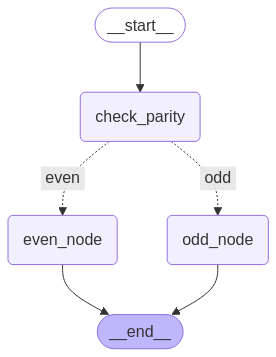

#### 1) State 정의

In [ ]:
class State(TypedDict):
    number: int
    result: str

#### 2) Node 정의

In [ ]:
# 노드: 짝/홀수 판별
def check_parity(state: State):
    print(f"check_parity: 입력된 숫자 = {state['number']}")
    return state  # 판단만 하고, 실제 처리는 다음 노드에서 함

# 짝수 노드
def even_node(state: State):
    print("짝수입니다!")
    state["result"] = "짝수입니다!"
    return state

# 홀수 노드
def odd_node(state: State):
    print("홀수입니다!")
    state["result"] = "홀수입니다!"
    return state

#### 3) 그래프 정의

In [ ]:
# 그래프 생성
builder = StateGraph(State)

# 노드 등록
builder.add_node("check_parity", check_parity)
builder.add_node("even_node", even_node)
builder.add_node("odd_node", odd_node)

# 조건 분기 연결
def parity_condition(state: State):
    return "even" if state["number"] % 2 == 0 else "odd"

builder.add_conditional_edges("check_parity", parity_condition,
                              {"even": "even_node", "odd": "odd_node"}
                              )

# 나머지 연결
builder.add_edge(START, "check_parity")
builder.add_edge("even_node", END)
builder.add_edge("odd_node", END)

# 그래프 컴파일
graph = builder.compile()

* 그래프 시각화

In [ ]:
# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

#### 4) Graph 실행

In [ ]:
state = {"number": 7, "result": ""}
result = graph.invoke(state)
print("최종 결과:", result)

### (2) 실습1

* check_score: 분기 기준 판단만 하고 상태는 변경하지 않음
* pass_node: "result"에 "합격" 저장
* fail_node: "result"에 "불합격" 저장

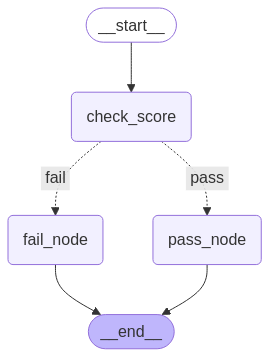

#### 1) State 정의

#### 2) Node 정의

#### 3) 그래프 정의

* 그래프 시각화

#### 4) Graph 실행

### (3) 실습2

* 목표 : 사용자의 감정을 판단해 다른 응답을 출력하는 조건 분기 라우팅 그래프 만들기

* 문제 설명 : 사용자로부터 입력받은 감정(문자열 "happy", "sad", "angry")에 따라 다른 노드를 호출하는 그래프를 만드시오.

* 조건:
    * 상태는 {"emotion": str, "response": str}
    * router 노드가 emotion 값을 기반으로 "happy", "sad", "angry" 중 하나의 노드로 분기
    * 각 감정 노드는 감정에 맞는 위로 또는 축하 메시지를 출력

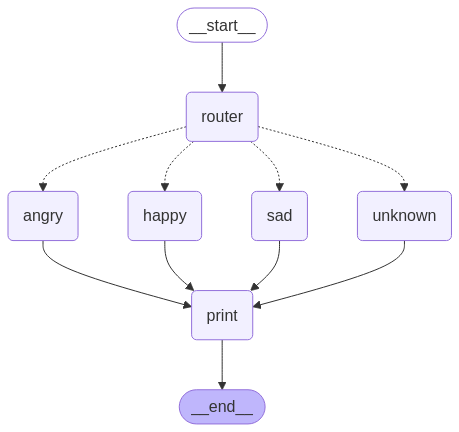

#### 1) State 정의

#### 2) Node 정의

#### 3) 그래프 정의

* 그래프 시각화

#### 4) Graph 실행

## 5.Graph 구축③: Reflection



### (1) reflect_node

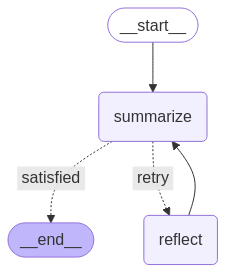

#### 1) State 정의

* input: 사용자의 입력
* summary: 요약된 결과 (간단하게 하드코딩 처리)
* is_satisfied: 결과에 만족했는지 여부
* log: 상태 변화를 기록하는 로그

In [ ]:
class State(TypedDict):
    input: str
    summary: str
    is_satisfied: bool
    log: list[str]

#### 2) Node 정의

In [ ]:
# 요약 노드: 간단히 결과 요약 + 만족 여부 결정
def summary_node(state: State):
    state["summary"] += " → 요약됨"
    state["log"].append("요약 수행")

    # 만족 여부 판단 (2회 이상 요약되면 만족했다고 가정)
    if state["summary"].count("요약됨") >= 2:
        state["is_satisfied"] = True
    else:
        state["is_satisfied"] = False
    print(state)
    return state

# 반추 노드: 추가 아이디어 도출 시도 (다시 생각해보기)
def reflect_node(state: State):
    state["log"].append("반추 수행")
    state["summary"] += " → 다시 생각해봄"
    print(state)
    return state

#### 3) 그래프 정의

In [ ]:
# 그래프 구성
builder = StateGraph(State)
builder.add_node("summarize", summary_node)
builder.add_node("reflect", reflect_node)

# 흐름 정의
builder.add_edge(START, "summarize")

# 조건 분기: 만족 여부에 따라 흐름 결정
def check_satisfaction(state: State):
    return "satisfied" if state["is_satisfied"] else "retry"

builder.add_conditional_edges("summarize", check_satisfaction,
                              {"satisfied": END, "retry": "reflect"})

# 반추 후 → 요약 다시 시도 (루프)
builder.add_edge("reflect", "summarize")

# 컴파일
graph = builder.compile()

* 그래프 시각화

In [ ]:
# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

#### 4) Graph 실행

In [ ]:
# 실행
initial_state = {"input": "오늘 하루 요약해줘", "summary": "", "is_satisfied": False, "log": [] }

result = graph.invoke(initial_state)
print("최종 상태:")
print(result)

### (2) 실습1

* 사용자가 오타가 있는 문장을 입력했을 때,
    * 에이전트가 그것을 수정 → 검사 → 수정 → 검사…
    * 하면서 "이제 충분히 고쳐졌다고 판단되면 종료"하는 구조를 만든다.

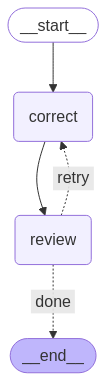

#### 1) State 정의

#### 2) Node 정의

* 노드 구성
    * correct: 오타 교정 시도 (문장 끝에 "✔" 추가)
    * review: 수정 결과를 검사 → 교정이 2번 이상 이루어졌으면 만족 상태로 판단



#### 3) 그래프 정의

* 그래프 시각화

#### 4) Graph 실행

### (3) 실습2

* 수 맞히기 게임
    * 랜덤 숫자(1~10)를 입력받아 맞힐 때까지 계속 추측하는 루프 구조 만들기
        * 노드의 실행 결과에 따라 같은 노드를 한 번 더 실행하거나,
        * 특정 조건을 만족하면 종료하거나 다른 노드로 이동할 수 있음
        * 흔히 쓰는 구조
            * judge 노드가 "retry" vs "next" 판단
            * → "retry"면 앞 노드로 되돌아가서 루프
            * → "next"면 다음 노드로 진행



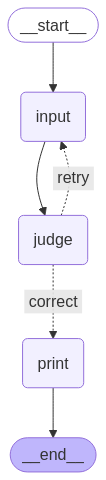

In [ ]:
import random

#### 1) State 정의

#### 2) Node 정의

#### 3) 그래프 정의

* 그래프 시각화

#### 4) Graph 실행